# Parameters

In [1]:
PREFIX = "TEST_10sec"

# Environment

In [2]:
from utils.noise_utils import (
    get_sounds,
    get_notes,
    sound_note_contains,
    get_data_loaders,
)
from utils.plot import plot_sounds
from lightning.pytorch import Trainer
from torchaudio.transforms import Spectrogram
from torch import device as torch_device, cuda, __version__

# from utils.noise_arquitecture import NoiseClassifier

__version__

'2.0.0'

# Import data

In [3]:
sounds, names = get_sounds(
    records_dir=f"data/tensors/{PREFIX}_resized_records.pt",
    names_dir=f"data/tensors/{PREFIX}_records_names.xz",
)

sound_notes = get_notes(
    csv_dir="data/physionet.org/files/ephnogram/1.0.0/ECGPCGSpreadsheet.csv",
    id_col="Record Name",
    notes_col="PCG Notes",
    names=names,
)
labels = sound_note_contains(sound_notes, contains="Good")

sounds[0], names[0], labels[0]

(tensor([[-0.0064, -0.0044, -0.0049,  ...,  0.0147,  0.0142,  0.0137]]),
 'ECGPCG0016',
 tensor([1.]))

# Plot records

In [9]:
from torch import Tensor
from numpy.random import shuffle as np_shuffle
from matplotlib.pyplot import subplots, show


def plot_sounds(
    sounds: Tensor, names: dict, labels: Tensor, n: int, spectrogram: bool, shuffle: bool
) -> None:
    data_len = len(sounds)
    idxs = list(range(data_len))

    if shuffle:
        np_shuffle(idxs)

    to_show = idxs[:n]

    sounds = sounds.squeeze()

    n_rows = 2 if spectrogram else 1
    fig, axs = subplots(n_rows, n)

    fig.set_figwidth(40)
    fig.suptitle(f'{n} {"random" if shuffle else ""} records:')

    for i in range(n):
        idx = to_show[i]
        name = names[idx]
        sound = sounds[idx]
        label = labels[idx].item()

        label = "Good" if label > 0.5 else "Bad"

        axs[0, i].plot(sound)
        axs[0, i].set_title(name)
        axs[1, i].specgram(sound)
        axs[1, i].set_xlabel(label, fontsize=18)

    show()

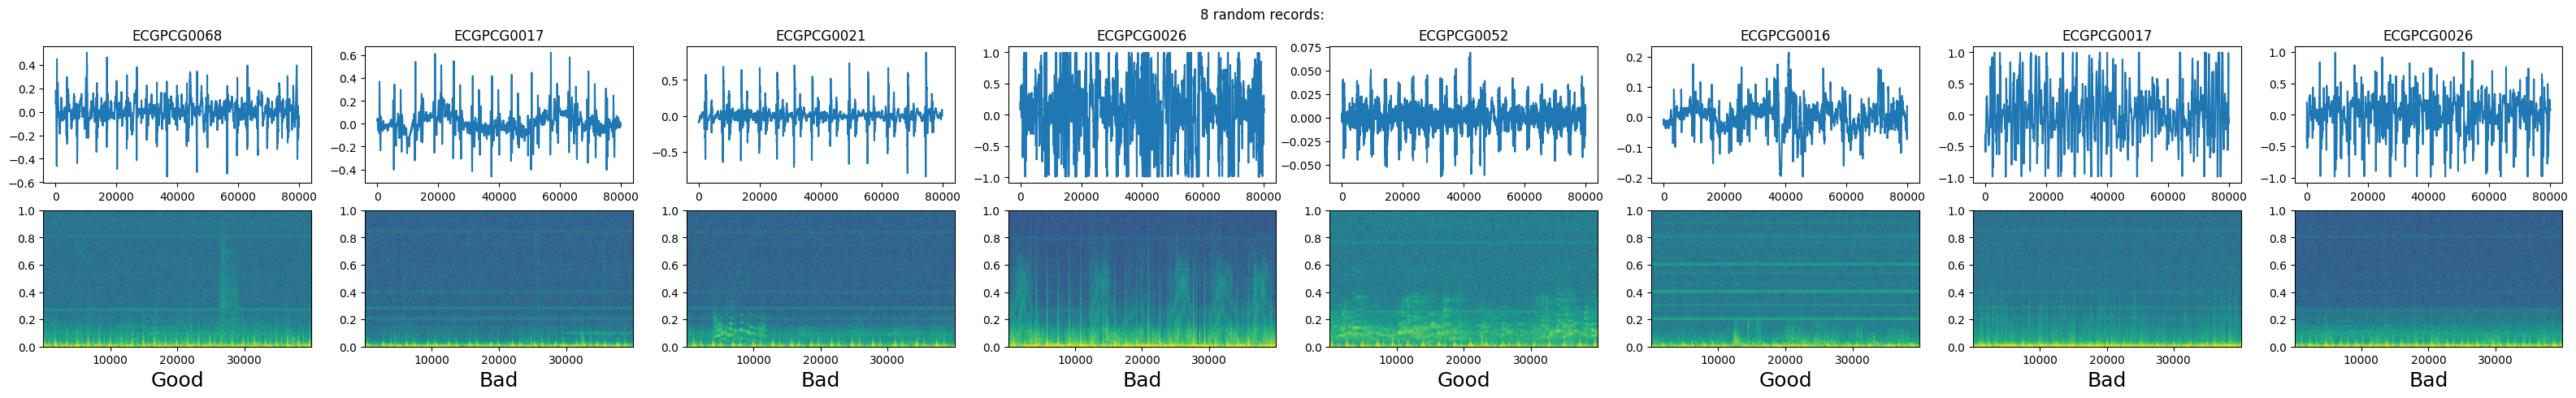

In [10]:
plot_sounds(
    sounds,
    names,
    labels,
    n=8,
    spectrogram=True,
    shuffle=True,
)

# Train and test

In [5]:
train, test = get_data_loaders(
    sounds,
    labels,
    batch_size=128,
    num_workers=1,
    transform=Spectrogram(),
)

train

# Model Architecture

In [6]:
from torch import flatten
from torch.optim import Adam
from collections import OrderedDict
from lightning.pytorch import LightningModule
from torch.nn.functional import binary_cross_entropy
from torch.nn import (
    Sequential,
    ReLU,
    LazyConv2d,
    MaxPool2d,
    LazyLinear,
    Sigmoid,
    BCEWithLogitsLoss,
)


class NoiseClassifier(LightningModule):
    def __init__(self):
        super().__init__()

        self.conv_net = Sequential(
            OrderedDict(
                [
                    ("C1", LazyConv2d(128, kernel_size=(5, 5))),
                    ("Relu1", ReLU()),
                    ("S2", MaxPool2d(kernel_size=(2, 2), stride=2)),
                    ("C3", LazyConv2d(256, kernel_size=(5, 5))),
                    ("Relu3", ReLU()),
                    ("S4", MaxPool2d(kernel_size=(2, 2), stride=2)),
                    ("C5", LazyConv2d(500, kernel_size=(5, 5))),
                    ("Relu5", ReLU()),
                ]
            )
        )

        self.fully_connected = Sequential(
            OrderedDict(
                [
                    ("F6", LazyLinear(450)),
                    ("Relu6", ReLU()),
                    ("F6", LazyLinear(100)),
                    ("Relu6", ReLU()),
                    ("F7", LazyLinear(1)),
                    ("Sigmoid", Sigmoid()),
                ]
            )
        )

    def forward(self, input):
        output = self.conv_net(input)
        output = flatten(output, start_dim=1)
        output = self.fully_connected(output)
        return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        accuracy = binary_cross_entropy(y_hat, y)
        self.log("train_accuracy", accuracy)

        loss_fn = BCEWithLogitsLoss()
        loss = loss_fn(y_hat, y)
        self.log("train_loss", loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        accuracy = binary_cross_entropy(y_hat, y)
        self.log("val_accuracy", accuracy)

        loss_fn = BCEWithLogitsLoss()
        loss = loss_fn(y_hat, y)
        self.log("val_loss", loss)

        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        return optimizer

In [7]:
noise_classifier = NoiseClassifier()
device = torch_device("cuda" if cuda.is_available() else "cpu")
noise_classifier = noise_classifier.to(device)

/Users/efrainflores/.local/share/virtualenvs/zhinsou_multimodal-ztvG-7-y/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Train

In [8]:
noise_classifier

NoiseClassifier(
  (conv_net): Sequential(
    (C1): LazyConv2d(0, 128, kernel_size=(5, 5), stride=(1, 1))
    (Relu1): ReLU()
    (S2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (C3): LazyConv2d(0, 256, kernel_size=(5, 5), stride=(1, 1))
    (Relu3): ReLU()
    (S4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (C5): LazyConv2d(0, 500, kernel_size=(5, 5), stride=(1, 1))
    (Relu5): ReLU()
  )
  (fully_connected): Sequential(
    (F6): LazyLinear(in_features=0, out_features=100, bias=True)
    (Relu6): ReLU()
    (F7): LazyLinear(in_features=0, out_features=1, bias=True)
    (Sigmoid): Sigmoid()
  )
)

In [9]:
trainer = Trainer(limit_train_batches=100, max_epochs=10, log_every_n_steps=30)
trainer.fit(model=noise_classifier, train_dataloaders=train, val_dataloaders=test)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/efrainflores/.local/share/virtualenvs/zhinsou_multimodal-ztvG-7-y/lib/python3.10/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:411: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name            | Type       | Params
-----------------------------------------------
0 | conv_net        | Sequential | 0     
1 | fully_connected | Sequential | 0     
-----------------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/efrainflores/.local/share/virtualenvs/zhinsou_multimodal-ztvG-7-y/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/efrainflores/.local/share/virtualenvs/zhinsou_multimodal-ztvG-7-y/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/efrainflores/.local/share/virtualenvs/zhinsou_multimodal-ztvG-7-y/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (39) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:   5%|▌         | 2/39 [00:28<08:39, 14.03s/it, v_num=2]

/Users/efrainflores/.local/share/virtualenvs/zhinsou_multimodal-ztvG-7-y/lib/python3.10/site-packages/lightning/pytorch/trainer/call.py:54: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
